# Problem 1: Exploring the SIR mean-field model

In this problem, we will examine how the network structure affects how well the Erdos-Renyi SIR mean field model captures the dynamics. Feel free to adapt the code we used in class.

### Setup
Upload the relevant packages`

In [1]:
from pylab import *
from IPython import display
import networkx as nx
import time
import math

# %matplotlib inline

## Problem 1A) Finding an ‘equivalent’ small-world network.
Let’s see if we can find an ‘equivalent’ small world network to match the Erdos-Renyi network we looked at in class. We can do this by setting the average degree of the small world network, k, equal to that of the Erdos-Renyi network. Calculate the average degree of an Erdos-Renyi network with N nodes and edge probability pe. (Note that there are a few ways to calculate this, usually using either that the probability of a single edge between two nodes is pe and/or that number of edges in an Erdos-Renyi network can be calculated as (N2)pe, i.e. the number of ways to choose two nodes times the probability that there exists an edge between that pair of nodes). From the number of edges, how can we work out the average degree of the network? Be sure to explain your reasoning as well as giving a formula for the average degree.

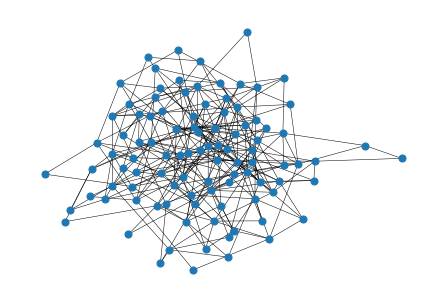

In [2]:
N = 100
p_e = 0.06

# Initialize network model
g_er = nx.erdos_renyi_graph(N,p_e)        # start with an ER graph
g_er.pos = nx.spring_layout(g_er)
nx.draw(g_er, node_size = 50, width = 0.5)
show()

- **Calculate the average node**

In [3]:
# Using the traits of the above generated node
degs = g_er.degree()
len(degs)
dict(degs)
K_actual= sum([d for (n,d) in g_er.degree()]) / g_er.number_of_nodes()
print("Average degree of above network:", K_actual)

# My guess
# 99 possible nodes connected to a single node
K = 99 * p_e
print("My calculated:", K)

Average degree of above network: 5.84
My calculated: 5.9399999999999995


**What is the average node degree?**
- I found a few ways to calculate the average degree of the network. First of all, because we used the Erdos Renyi function to create the network, there is not a constant network degree and no consistent average degree with repeated networks. So for each network, I can calculate the average degree by summing the degrees of of the nodes in the network and then divide that by the sum of all of the nodes.

- Another option would be to calculate the expected degree. For any given node, there are N-1 other nodes in the network with which an edge to connect. Therefore, the probability of of an edge * the number of edges is the expected number of edges or degree for each node in the network.

## Problem 1B) Implementing the simulation on a small-world network. 
Now that we know what average degree to use, adapt the SIR model on an Erdos-Renyi network that we used in class to run on a Watts-Strogatz network. You can do this as follows:

### Update the `initialize()` function
In your `initialize()` function, change the network from the `nx.erdos_renyi_graph()` function, to use the `nx.watts_strogatz_graph()` function. This function takes three arguments: N, the number of nodes, k, the average degree (i.e. number of ring neighbors to connect to), and β, the rewiring probability.
For the number of neighbors to connect to, calculate the average degree using the formula you derived in 1A, using an edge probability of **pe=0.06**. Note that you will need to round your answer to the nearest integer, since you can only connect to an integer number of neighbors.
For the other parameters, take pi=pr=0.1 and N=100. We will try out a range of different β values, so set it to whatever you like for now.

- **Calculate the value of k**

In [4]:
# keep these global
N = 100
p_i = 0.1
p_r = 0.1
p_e = 0.06

# Calculate the average degree (K) of the network
# Use the result from above
K = K_actual 

print("Using K=", K)

Using K= 5.84


In [5]:
# initialize the prevalence
prev = []    # prevalence (total infected nodes/total nodes) in the network model
prev_mf = [] # prevalence (total infected nodes/total nodes) in the mean field model
susc_mf = [] # fraction of nodes that are susceptible in the mean field model

In [6]:
def initialize(beta):
    global g, nextg, prev, prev_mf, susc_mf
    prev = []
    prev_mf = []
    susc_mf = []
    
    #**#**#**#**#**#**#***#**#**#**#**#**#
    # Initialize network model
    # UPDATE THE CREATION OF THE GRAPH
    g = nx.watts_strogatz_graph(n=N, k=round(K), p=beta)
    # N , the number of nodes, k, the average degree 
    #     (i.e. number of ring neighbors to connect to), and β, the rewiring probability.
    # every node can be rewired
    #**#**#**#**#**#**#***#**#**#**#**#**#
    
    g.pos = nx.spring_layout(g)
    nx.set_node_attributes(g, 0, 'state')  # everyone starts off susceptible
    g.nodes[1]['state'] = 1                 # set one node to be infected (index case)
    nextg = g.copy()
    nextg.pos = g.pos
    prev.append(1/len(g.nodes)) # initial prevalence in the real graph
    
    # Initialize mean field model
    susc_mf.append((N-1)/N) # initial susceptible fraction in the mean field model
    prev_mf.append(1/N) # initial prevalence in the mean field model

### Model from class

In [7]:
# Update Function
def update():
    global g, nextg, prev, prev_mf, susc_mf
    
    # Update network model
    curprev = 0
    nextg = g.copy()
    nextg.pos = g.pos
    for a in g.nodes:
        if g.nodes[a]['state'] == 0: # if susceptible
            nextg.nodes[a]['state'] = 0
            for b in g.neighbors(a):
                if g.nodes[b]['state'] == 1: # if neighbor b is infected
                    if random() < p_i:
                        nextg.nodes[a]['state'] = 1
        elif g.nodes[a]['state'] ==1: # if infected
            curprev += 1
            nextg.nodes[a]['state'] = 2 if random() < p_r else 1
    prev.append(curprev/len(g.nodes()))
    g = nextg.copy()
    g.pos = nextg.pos
    
    # Update mean field model
    susc_mf.append(susc_mf[-1] - (N-1)*p_e*p_i*prev_mf[-1]*susc_mf[-1])
    prev_mf.append(prev_mf[-1] + (N-1)*p_e*p_i*prev_mf[-1]*susc_mf[-1] - p_r*prev_mf[-1])

In [8]:
def observe():
    global g, prev, prev_mf, susc_mf
    cla()
    nx.draw(g, cmap = cm.plasma, vmin = 0, vmax = 2,
            node_color = [g.nodes[i]['state'] for i in g.nodes],
            pos = g.pos)

### *Run the model for different values of $\beta$*
Implement the model and run it for a few different β values. How well does the Erdos-Renyi mean field model perform as you change β from 0 to 1? In your write-up, be sure to include a couple of plots of the prevalence (fraction of the population that is infected) over time, comparing the Erdos-Renyi mean field prediction to the Watts-Strogatz network simulation.

**How well does the Erdos-Renyi mean field model perform as you change β from 0 to 1?**
- For small values of $\beta$ the model performed very poorly. It was only connected to adjacent nodes, so without rewiring, the number of infected people was slow to increase and did not reach a peak comparable to the erdos renyi model and the mean field model.

- As we increased beta, the simulation approached the mean field model. Ringlike networks became more evenly connected and infected individuals appeared all along the network and it was more easily spread. For value of $\beta > 0.5$, the simulation was relatively similar to the mean field model.

- ***See example plots below***

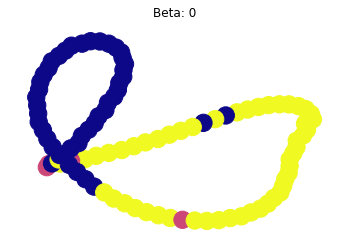

In [9]:
# beta/p is 0 
prev = []    # prevalence (total infected nodes/total nodes) in the network model
prev_mf = [] # prevalence (total infected nodes/total nodes) in the mean field model
susc_mf = [] # fraction of nodes that are susceptible in the mean field model

beta = 0

initialize(beta = beta)
figure()
for i in range(50):
  update()
observe()
title("Beta: {0}".format(beta))
display.clear_output(wait=True)


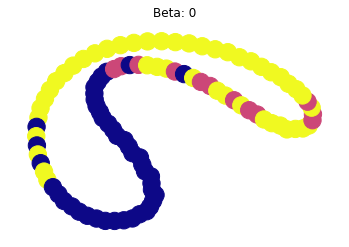

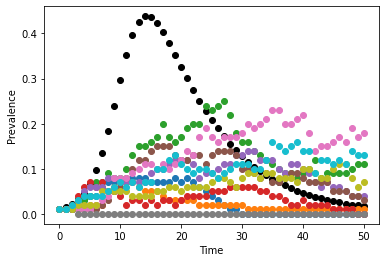

In [10]:
prevs = []
beta = 0

for iter in range(10):
    # beta/p is 0 
    prev = []    # prevalence (total infected nodes/total nodes) in the network model
    prev_mf = [] # prevalence (total infected nodes/total nodes) in the mean field model
    susc_mf = [] # fraction of nodes that are susceptible in the mean field model

    initialize(beta)
    for i in range(50):
      update()
    prevs.append(prev)
    
    
observe()
title("Beta: {0}".format(beta))

display.clear_output(wait=True)


# now plot the results
figure()
scatter(range(len(prev_mf)), prev_mf, color = 'black')
for prev in prevs:
    scatter(range(len(prev)), prev)
xlabel("Time")
ylabel("Prevalence")
show()

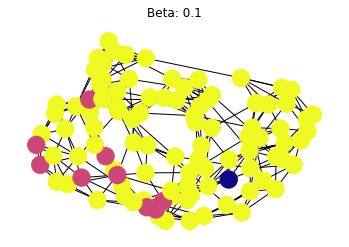

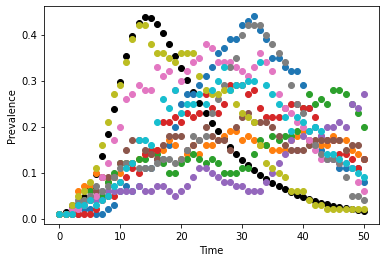

In [11]:
prevs = []
beta = 0.1

for iter in range(10):
    # beta/p is 0 
    prev = []    # prevalence (total infected nodes/total nodes) in the network model
    prev_mf = [] # prevalence (total infected nodes/total nodes) in the mean field model
    susc_mf = [] # fraction of nodes that are susceptible in the mean field model

    initialize(beta)
    for i in range(50):
      update()
    prevs.append(prev)
    
    
observe()
title("Beta: {0}".format(beta))

display.clear_output(wait=True)


# now plot the results
figure()
scatter(range(len(prev_mf)), prev_mf, color = 'black')
for prev in prevs:
    scatter(range(len(prev)), prev)
xlabel("Time")
ylabel("Prevalence")
show()

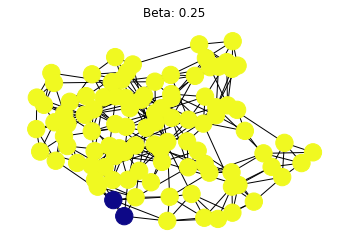

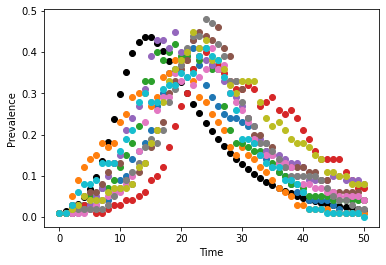

In [12]:
prevs = []
beta = 0.25

for iter in range(10):
    # beta/p is 0 
    prev = []    # prevalence (total infected nodes/total nodes) in the network model
    prev_mf = [] # prevalence (total infected nodes/total nodes) in the mean field model
    susc_mf = [] # fraction of nodes that are susceptible in the mean field model

    initialize(beta)
    for i in range(50):
      update()
    prevs.append(prev)
    
    
observe()
title("Beta: {0}".format(beta))

display.clear_output(wait=True)


# now plot the results
figure()
scatter(range(len(prev_mf)), prev_mf, color = 'black')
for prev in prevs:
    scatter(range(len(prev)), prev)
xlabel("Time")
ylabel("Prevalence")
show()

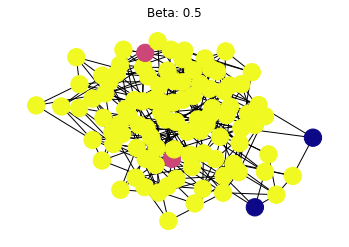

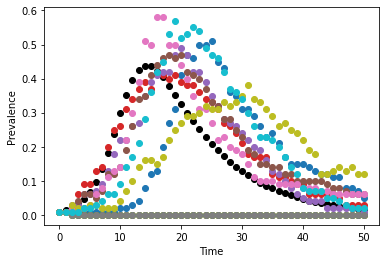

In [13]:
prevs = []
beta = 0.5

for iter in range(10):
    # beta/p is 0 
    prev = []    # prevalence (total infected nodes/total nodes) in the network model
    prev_mf = [] # prevalence (total infected nodes/total nodes) in the mean field model
    susc_mf = [] # fraction of nodes that are susceptible in the mean field model

    initialize(beta)
    for i in range(50):
      update()
    prevs.append(prev)
    
    
observe()
title("Beta: {0}".format(beta))

display.clear_output(wait=True)


# now plot the results
figure()
scatter(range(len(prev_mf)), prev_mf, color = 'black')
for prev in prevs:
    scatter(range(len(prev)), prev)
xlabel("Time")
ylabel("Prevalence")
show()

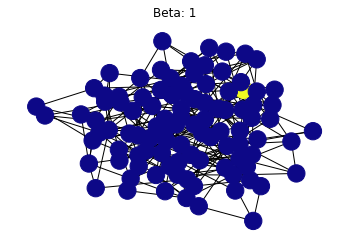

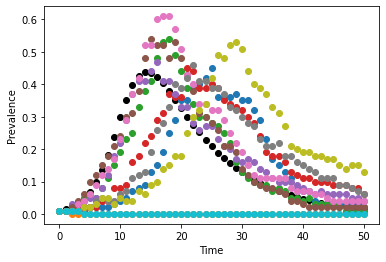

In [14]:
prevs = []
beta = 1

for iter in range(10):
    # beta/p is 0 
    prev = []    # prevalence (total infected nodes/total nodes) in the network model
    prev_mf = [] # prevalence (total infected nodes/total nodes) in the mean field model
    susc_mf = [] # fraction of nodes that are susceptible in the mean field model

    initialize(beta)
    for i in range(50):
      update()
    prevs.append(prev)
    
    
observe()
title("Beta: {0}".format(beta))

display.clear_output(wait=True)


# now plot the results
figure()
scatter(range(len(prev_mf)), prev_mf, color = 'black')
for prev in prevs:
    scatter(range(len(prev)), prev)
xlabel("Time")
ylabel("Prevalence")
show()

## Problem 1C) Exploring the Erdos-Renyi mean-field model performance. 
Running one or two simulations is often not enough to really explore the model behavior, particularly for a stochastic model like this one. Adjust your code so that for a given parameter set, you run at least 100 simulations for 100 timesteps each.

In [15]:
timesteps = 100
def plot_beta(beta = 1):
    global prev
    global timesteps
    timesteps = 100  # number of timesteps per simulation
    numsims = 100    # number of simulations to run

    # this array will store the time series of fraction infected for each simulation
    prevarray = np.zeros([timesteps,numsims])  
    figure()

    for i in range(numsims):        # loop over all simulations
        initialize(beta)                  # initialize each simulation
        prev = []
        for j in range(timesteps):  # loop over the timesteps for that simulation
            update()                  # update
        prevarray[:,i] = prev         # store the resulting simulation in prevarray

        # plot all of these
        scatter(range(timesteps), prev, s=5)


    plot(range(timesteps),prev_mf[0:100],'k', linewidth=4)
    title("beta =" + str(beta))
    xlabel('time')
    ylabel('proportion infected')
    show()
    return {"beta":beta, "mf":prev_mf[0:100], "sim":prevarray}

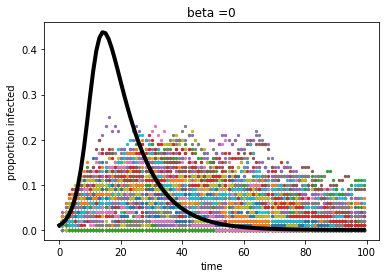

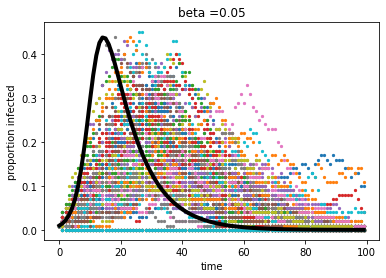

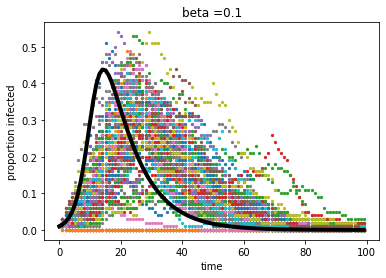

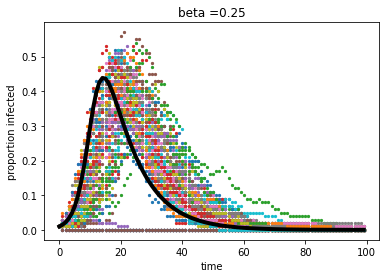

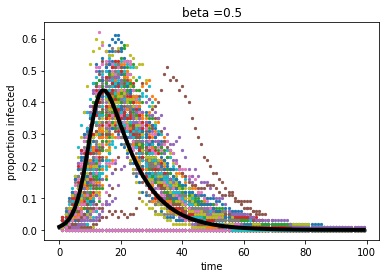

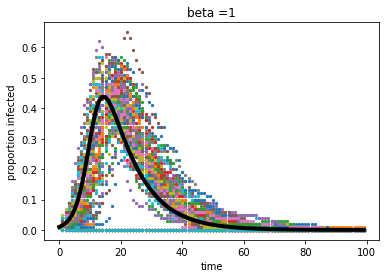

In [16]:
beta0 = plot_beta(0)
beta1 = plot_beta(0.05)
beta2 = plot_beta(0.1)
beta3 = plot_beta(0.25)
beta4 = plot_beta(0.5)
beta5 = plot_beta(1)

### Problem 1D) Capturing uncertainty. 
To more effectively capture the range of uncertainty in our simulations, adjust the plots you made in Problem 1C to plot the median across your simulations, the 5% and 95% quantiles, and the mean-field model prediction. For this, you may want to use two python functions: np.quantile() (part of the numpy package) and fill_between() part of the pyplot package. Take a look at the documentation for these two functions to figure out how to use them with your model output (and feel free to ask me if you have trouble with them).

Redo the plots for the five (or more) different values of β from Problem 1C. How well does the Erdos-Renyi mean field model capture the dynamics as β changes? Would you feel comfortable using the mean field model for this system (and if so, for what values of β)?


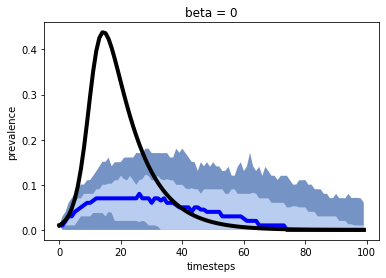

In [17]:
fill_between(range(timesteps), np.quantile(beta0["sim"], .05, axis = 1), 
             np.quantile(beta0["sim"], .95, axis = 1), facecolor='#7593C4')
fill_between(range(timesteps), np.quantile(beta0["sim"], .25, axis = 1), 
             np.quantile(beta0["sim"], .75, axis = 1), facecolor='#B8CDEF')
plot(range(timesteps), np.quantile(beta0["sim"], .5, axis = 1), 'b',linewidth = 4)
plot(range(timesteps),beta0["mf"],'k', linewidth=4)
title("beta = " + str(beta0["beta"]))
xlabel("timesteps")
ylabel("prevalence")
show()

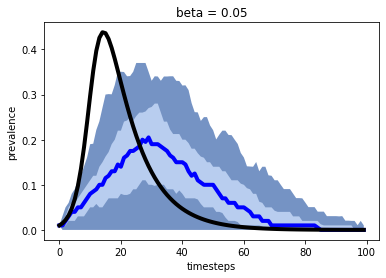

In [18]:
fill_between(range(timesteps), np.quantile(beta1["sim"], .05, axis = 1), 
             np.quantile(beta1["sim"], .95, axis = 1), facecolor='#7593C4')
fill_between(range(timesteps), np.quantile(beta1["sim"], .25, axis = 1), 
             np.quantile(beta1["sim"], .75, axis = 1), facecolor='#B8CDEF')
plot(range(timesteps), np.quantile(beta1["sim"], .5, axis = 1), 'b',linewidth = 4)
plot(range(timesteps),beta1["mf"],'k', linewidth=4)
title("beta = " + str(beta1["beta"]))
xlabel("timesteps")
ylabel("prevalence")
show()

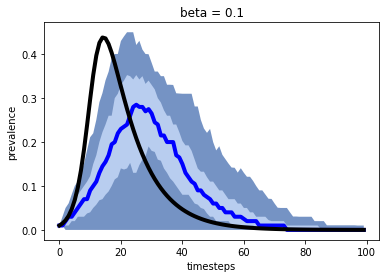

In [19]:
fill_between(range(timesteps), np.quantile(beta2["sim"], .05, axis = 1), 
             np.quantile(beta2["sim"], .95, axis = 1), facecolor='#7593C4')
fill_between(range(timesteps), np.quantile(beta2["sim"], .25, axis = 1), 
             np.quantile(beta2["sim"], .75, axis = 1), facecolor='#B8CDEF')
plot(range(timesteps), np.quantile(beta2["sim"], .5, axis = 1), 'b',linewidth = 4)
plot(range(timesteps),beta2["mf"],'k', linewidth=4)
title("beta = " + str(beta2["beta"]))
xlabel("timesteps")
ylabel("prevalence")
show()

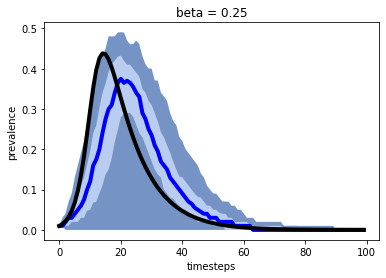

In [20]:
fill_between(range(timesteps), np.quantile(beta3["sim"], .05, axis = 1), 
             np.quantile(beta3["sim"], .95, axis = 1), facecolor='#7593C4')
fill_between(range(timesteps), np.quantile(beta3["sim"], .25, axis = 1), 
             np.quantile(beta3["sim"], .75, axis = 1), facecolor='#B8CDEF')
plot(range(timesteps), np.quantile(beta3["sim"], .5, axis = 1), 'b',linewidth = 4)
plot(range(timesteps),beta3["mf"],'k', linewidth=4)
title("beta = " + str(beta3["beta"]))
xlabel("timesteps")
ylabel("prevalence")
show()

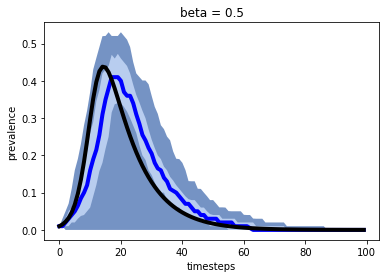

In [21]:
fill_between(range(timesteps), np.quantile(beta4["sim"], .05, axis = 1), 
             np.quantile(beta4["sim"], .95, axis = 1), facecolor='#7593C4')
fill_between(range(timesteps), np.quantile(beta4["sim"], .25, axis = 1), 
             np.quantile(beta4["sim"], .75, axis = 1), facecolor='#B8CDEF')
plot(range(timesteps), np.quantile(beta4["sim"], .5, axis = 1), 'b',linewidth = 4)
plot(range(timesteps),beta4["mf"],'k', linewidth=4)
title("beta = " + str(beta4["beta"]))
xlabel("timesteps")
ylabel("prevalence")
show()

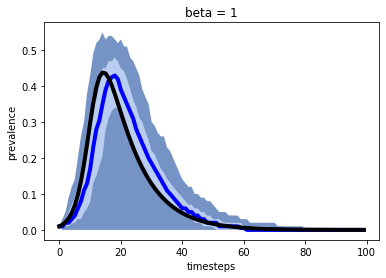

In [22]:
fill_between(range(timesteps), np.quantile(beta5["sim"], .05, axis = 1), 
             np.quantile(beta5["sim"], .95, axis = 1), facecolor='#7593C4')
fill_between(range(timesteps), np.quantile(beta5["sim"], .25, axis = 1), 
             np.quantile(beta5["sim"], .75, axis = 1), facecolor='#B8CDEF')
plot(range(timesteps), np.quantile(beta5["sim"], .5, axis = 1), 'b',linewidth = 4)
plot(range(timesteps),beta5["mf"],'k', linewidth=4)
title("beta = " + str(beta5["beta"]))
xlabel("timesteps")
ylabel("prevalence")
show()

**How well does the Erdos-Renyi mean field model capture the dynamics as β changes? Would you feel comfortable using the mean field model for this system (and if so, for what values of β)?**
- As was mentioned in a previous response, the Erdos-Renyi mean field model captures the dynamics of the small-world simulation better as $\beta$ increases and approaches 1. The approximation is poor for values of $\beta < 0.5$. Around then, the mean field model remains outside of the .75 area shaded in light blue. The approximation is especially poor when $\beta$ is 0 and 0.1.

- I would feel comfortable using the mean field model for this system if I were using values of $\beta > 0.5$, but I would be especially confident for $\beta = 1$. Although the mean field model does not fall exactly along the median of the simulation, its performance is very similar compared the Erdo-Renyi simulations from class.

### Problem 1E) Comparing Watts-Strogatz vs. Erdos-Renyi. 
Finally, make one more plot like you did in Problem 1D, but now for the Erdos-Renyi graph with pe=0.06. Compare this to the Watts-Strogatz plot you made for β=1 in Problem 1D. How well does the mean field model capture the model behavior for the most random Watts-Strogatz network vs. for the Erdos-Renyi network?

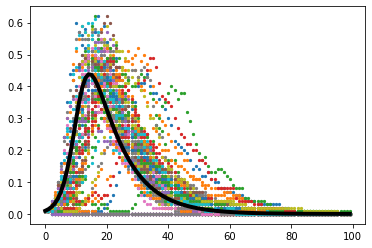

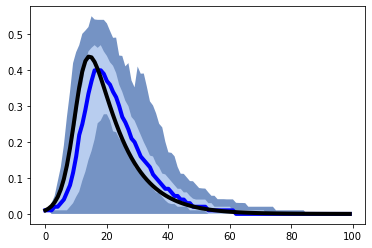

In [23]:
# make a plot with the Erdos-Renyi graph with pe = 0.06
# compare with the plot above
# I need to fix/make new initialize function
p_e = 0.06
prev = []

def initialize_er():
    global g, nextg, prev, prev_mf, susc_mf
    
    # Initialize network model
    g = nx.erdos_renyi_graph(N,p_e)        # start with an ER graph
    g.pos = nx.spring_layout(g)
    nx.set_node_attributes(g, 0, 'state')  # everyone starts off susceptible
    g.nodes[1]['state'] = 1                 # set one node to be infected (index case)
    nextg = g.copy()
    nextg.pos = g.pos
    prev.append(1/len(g.nodes)) # initial prevalence in the real graph
    
    # Initialize mean field model
    susc_mf.append((N-1)/N) # initial susceptible fraction in the mean field model
    prev_mf.append(1/N) # initial prevalence in the mean field model


timesteps = 100
numruns = 100
prevarray = np.zeros([timesteps,numruns])
figure()
for i in range(0,numruns):
    prev = []    # prevalence (total infected nodes/total nodes) in the network model
    prev_mf = [] # prevalence (total infected nodes/total nodes) in the mean field model
    susc_mf = [] # fraction of nodes that are susceptible in the mean field model
    initialize_er()
    for j in range(1,timesteps):
        update()
    prevarray[:,i] = prev
    scatter(range(timesteps), prev, s=5)
plot(range(timesteps),prev_mf,'k', linewidth=4)
show()


fill_between(range(timesteps), np.quantile(prevarray, .05, axis = 1), 
             np.quantile(prevarray, .95, axis = 1), facecolor='#7593C4')
fill_between(range(timesteps), np.quantile(prevarray, .25, axis = 1), 
             np.quantile(prevarray, .75, axis = 1), facecolor='#B8CDEF')
plot(range(timesteps), np.quantile(prevarray, .5, axis = 1), 'b',linewidth = 4)
plot(range(timesteps),prev_mf,'k', linewidth=4)
show()

**Compare this to the Watts-Strogatz plot you made for β=1 in Problem 1D. How well does the mean field model capture the model behavior for the most random Watts-Strogatz network vs. for the Erdos-Renyi network?**
- Like I mentioned in the previous question, the ability for the mean field model to capture the behavior of the simulations of Erdos-Renyi and Watts-Strogatz models is comparable. Comparing the model for p = 0.06 and beta = 1, it avtually seems like the Erdos-Renyi mean field model performs better at capturing the dynamics observed in the Watts-Strogatz simulations.

# Problem 2: Cascading failure on a power grid


In [24]:
# initialize the important variables
N = 100 # nodes
m = 2 #each node is attached to m existing nodes

In [25]:
# make the network

class Grid:
    
    def __init__(self, N = 100, m = 2, init_load = 0.2, g = None):
        self.N = N
        self.m = m
        
        if g is None:
            self.g = nx.barabasi_albert_graph(N,m)
        else:
            self.g = g
            self.N = len(self.g.nodes)
        
        self.prop = [0]
        self.init_load = init_load
        
        # set up the rest of the grid and give everything their attributes
        self.g.pos = nx.spring_layout(self.g)
        nx.set_node_attributes(self.g, 0, 'max_cap')
        nx.set_node_attributes(self.g, 0, 'elec_load')
        nx.set_node_attributes(self.g, True, 'running')

        for node in self.g.nodes:
            max = np.random.normal(100, 10)
            self.g.nodes[node]['max_cap'] = max
            self.g.nodes[node]['elec_load'] = np.random.uniform((self.init_load * max), max)

    
    def update(self):
        # update the network model
        # Update network model
        curprev = 0
        nextg = self.g.copy()
        nextg.pos = self.g.pos

        for a in self.g.nodes:
            if self.g.nodes[a]['running']:
                if (self.g.nodes[a]['elec_load'] > self.g.nodes[a]['max_cap']): # if max capacity is less than current load
                    nextg.nodes[a]['running'] = False # the node fails
                    # evenly distribute to the neibhboors
                    
                    neigh = [n for n in self.g.neighbors(a) if nextg.nodes[n]['running']]
                    #all_neigh = array(self.g.neighbors())
                    #run_neigh = []
                    
                    #for n in all_neigh
                    
                    
                    
                    
                    # neigh = [if g.nodes[n]['running']]
                    if (len(neigh) != 0 ):
                        load_dist = self.g.nodes[a]['elec_load']/(len(neigh))
                        for n in neigh:
                            nextg.nodes[n]['elec_load'] += load_dist
        self.g = nextg.copy()
        self.g.pos = nextg.pos
        
        self.prop.append(1 - (sum([self.g.nodes[n]['running'] for n in self.g])/self.N))
        
    def observe(self, delay = False):
        colors = {True:'yellow', False:'black'}
        cla()
        nx.draw(self.g,
                node_color = [colors[self.g.nodes[i]['running']] for i in self.g.nodes],
                node_size = [100 * (self.g.nodes[i]['elec_load']/self.g.nodes[i]['max_cap']) for i in self.g.nodes],
                pos = self.g.pos)
        
    def overload(self, Num_overload = 1):
        overload_nodes = np.random.randint(0,self.N, Num_overload)
        print('overloaded nodes:', overload_nodes)
        for i in overload_nodes:
            self.g.nodes[i]['elec_load'] = 125
        
        
        # self.g.nodes[np.random.randint(0,N)]['elec_load'] = 125 #overload a node!

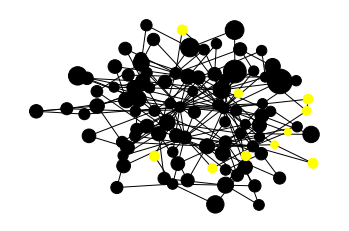

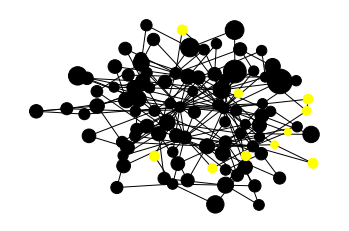

In [26]:
t = 25

grid = Grid()
grid.overload()
for i in range(t):
    grid.update()
    grid.observe()
    display.clear_output(wait=True)
    display.display(gcf())
    time.sleep(0.1)

overloaded nodes: [16]
overloaded nodes: [61]
overloaded nodes: [7]
overloaded nodes: [5]
overloaded nodes: [99]
overloaded nodes: [69]
overloaded nodes: [47]
overloaded nodes: [79]
overloaded nodes: [95]
overloaded nodes: [96]
overloaded nodes: [75]
overloaded nodes: [73]
overloaded nodes: [98]
overloaded nodes: [36]
overloaded nodes: [16]
overloaded nodes: [23]
overloaded nodes: [85]
overloaded nodes: [56]
overloaded nodes: [22]
overloaded nodes: [11]


Text(0.5, 1.0, 'Blackout Simulations')

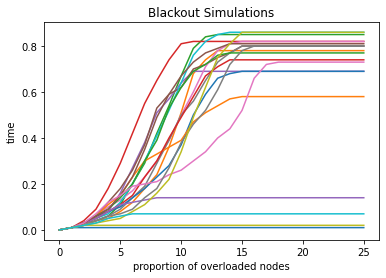

In [27]:
t = 25
reps = 20

grid_props = []

for j in range(reps):
    grid = Grid()
    grid.overload()
    for i in range(t):
        grid.update()
        grid_props.append(grid.prop)
    plot(range(t+1), grid.prop)
xlabel('proportion of overloaded nodes')
ylabel('time')
title('Blackout Simulations')


**What dynamics do you observe? You may need to try this a couple of times. Include any relevant plots to illustrate the dynamics you see.**
- For these initial conditions, the blackout varies in size, severity, and rate of spread.
- Most of the blackouts reached a maximum in about 10-20 timesteps. Rarely did it ever rach a full blackout. Often, ~80% of the nodes experienced a blackout.
- Invariably, there were a few cloackouts where the initial overloaded node did not cause a widespread blackout. Presumably, the overload experienced by the first node was able to be accomodated by the surrounding nodes without overloading them and prompting the blackout to expand.
- Generally, the blackouts exhibit a logistic-like curve where initially the blackout spreads slowly until about 5 timesteps and it quickly accelerates and spreads at a much higher rate.

### Problem 2B) Adjusted initial confitions
Next, try adjusting the initial load ranges to be closer or further from the maximum capacity (e.g. compare loads ranging from 10-100%, 50-100%, and 80-100%, etc.). 


overloaded nodes: [33]
overloaded nodes: [27]
overloaded nodes: [25]
overloaded nodes: [35]
overloaded nodes: [91]
overloaded nodes: [90]
overloaded nodes: [66]
overloaded nodes: [61]
overloaded nodes: [51]
overloaded nodes: [39]
overloaded nodes: [52]
overloaded nodes: [66]
overloaded nodes: [56]
overloaded nodes: [82]
overloaded nodes: [27]
overloaded nodes: [24]
overloaded nodes: [67]
overloaded nodes: [40]
overloaded nodes: [72]
overloaded nodes: [92]


Text(0.5, 1.0, 'Blackout Simulations [initial load : (0.05,1)]')

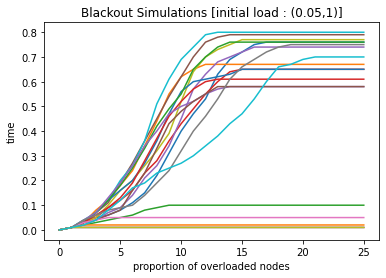

In [28]:
t = 25
reps = 20
init_load = 0.05

grid_props = []

for j in range(reps):
    grid = Grid(init_load = init_load)
    grid.overload()
    for i in range(t):
        grid.update()
        grid_props.append(grid.prop)
    plot(range(t+1), grid.prop)
xlabel('proportion of overloaded nodes')
ylabel('time')
title('Blackout Simulations [initial load : ({},1)]'.format(init_load))

overloaded nodes: [61]
overloaded nodes: [24]
overloaded nodes: [82]
overloaded nodes: [27]
overloaded nodes: [95]
overloaded nodes: [23]
overloaded nodes: [21]
overloaded nodes: [21]
overloaded nodes: [72]
overloaded nodes: [63]
overloaded nodes: [66]
overloaded nodes: [34]
overloaded nodes: [93]
overloaded nodes: [37]
overloaded nodes: [46]
overloaded nodes: [37]
overloaded nodes: [60]
overloaded nodes: [10]
overloaded nodes: [13]
overloaded nodes: [99]


Text(0.5, 1.0, 'Blackout Simulations [initial load : (0.1,1)]')

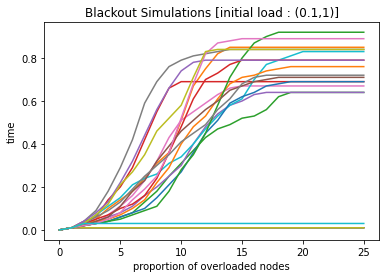

In [29]:
t = 25
reps = 20
init_load = 0.1

grid_props = []

for j in range(reps):
    grid = Grid(init_load = init_load)
    grid.overload()
    for i in range(t):
        grid.update()
        grid_props.append(grid.prop)
    plot(range(t+1), grid.prop)
xlabel('proportion of overloaded nodes')
ylabel('time')
title('Blackout Simulations [initial load : ({},1)]'.format(init_load))

overloaded nodes: [98]
overloaded nodes: [54]
overloaded nodes: [28]
overloaded nodes: [70]
overloaded nodes: [85]
overloaded nodes: [64]
overloaded nodes: [75]
overloaded nodes: [49]
overloaded nodes: [85]
overloaded nodes: [0]
overloaded nodes: [51]
overloaded nodes: [87]
overloaded nodes: [74]
overloaded nodes: [15]
overloaded nodes: [9]
overloaded nodes: [22]
overloaded nodes: [53]
overloaded nodes: [52]
overloaded nodes: [69]
overloaded nodes: [61]


Text(0.5, 1.0, 'Blackout Simulations [initial load : (0.5,1)]')

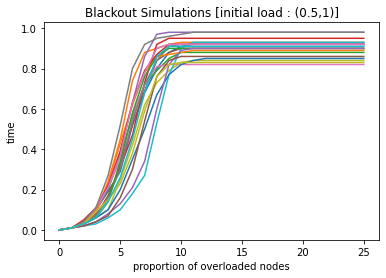

In [30]:
t = 25
reps = 20
init_load = 0.5

grid_props = []

for j in range(reps):
    grid = Grid(init_load = init_load)
    grid.overload()
    for i in range(t):
        grid.update()
        grid_props.append(grid.prop)
    plot(range(t+1), grid.prop)
xlabel('proportion of overloaded nodes')
ylabel('time')
title('Blackout Simulations [initial load : ({},1)]'.format(init_load))

overloaded nodes: [4]
overloaded nodes: [67]
overloaded nodes: [83]
overloaded nodes: [1]
overloaded nodes: [31]
overloaded nodes: [2]
overloaded nodes: [46]
overloaded nodes: [24]
overloaded nodes: [34]
overloaded nodes: [84]
overloaded nodes: [57]
overloaded nodes: [24]
overloaded nodes: [17]
overloaded nodes: [80]
overloaded nodes: [72]
overloaded nodes: [43]
overloaded nodes: [12]
overloaded nodes: [24]
overloaded nodes: [17]
overloaded nodes: [91]


Text(0.5, 1.0, 'Blackout Simulations [initial load : (0.9,1)]')

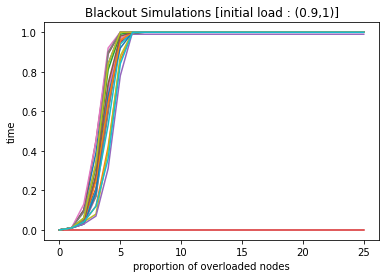

In [31]:
t = 25
reps = 20
init_load = 0.9

grid_props = []

for j in range(reps):
    grid = Grid(init_load = init_load)
    grid.overload()
    for i in range(t):
        grid.update()
        grid_props.append(grid.prop)
    plot(range(t+1), grid.prop)
xlabel('proportion of overloaded nodes')
ylabel('time')
title('Blackout Simulations [initial load : ({},1)]'.format(init_load))

**How does the size and frequency of the cascade failures change?**
- Starting at the lowest initial load range (0.05), the blackouts spread at slower rates and result in smaller blackouts.
- As the lower bound of the range increases, the rate of blackout spread increase and so does the average size of the blackout at the end of the simulation. The variance of the blackout size for each timestep decreases, meaning that the spread becomes more consistent across simulations as the range shrinks. The time for the maximum blackout size to be reached occurs sooner for higher lower bounds.
- For initial loads between 0.9 and 1, a  complete blackout occurs by around 5 timesteps almost invariably. Because of the lack of a substantial buffer, the initial overload cannot be accomodated, so it quickly prompts all of the neighboring nodes to experience an overlaod and continue to spread.




## Now for some real world networks!!

### Problem 2C) Western United States Power Grid
Now that we have the model running, let’s try it with a real-world power grid network. Download the Western United States power grid network from Mark Newman’s website (it’s listed as ‘Power grid’), from D. J. Watts and S. H. Strogatz, Nature 393, 440-442 (1998).
- 4941 nodes

In [32]:
# load the network
# be careful there are many nodes
g = nx.read_gml('power/power.gml',label='id')
pos=nx.spectral_layout(g)

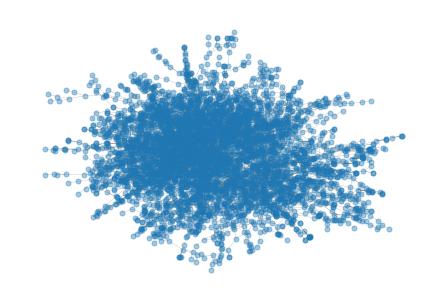

In [33]:
nx.draw(g,
        node_size = 25, width = 0.25,
        alpha = 0.4 )

**How does the network structure look? Does it look like the simulated networks we generated earlier?** 
- (It is admittedly hard to get a good view of the network structure with so many nodes. At least in the center of the network, it is nearly impossible to glean any information about network structure, connectance, nestedness, etc. It really just looks like a blue blob.

- On the outskirts of the network, it does seem like they are less connected. Large branches or leaves extend out from the center of the network were a single node has only two edges and is not apart of any loop. There appears to be far more nodes with only one edge.

- This is distinct from the networks we generated earlier. Those had far more loops and were at least more connected on the outskirts of the network. I also imagine, given the function we used to generate the network, that it is a little more uniformly connected throughout the network, whereas this network has more variation.



**Then plot the network degree distribution (on a log-log scale).** See below.

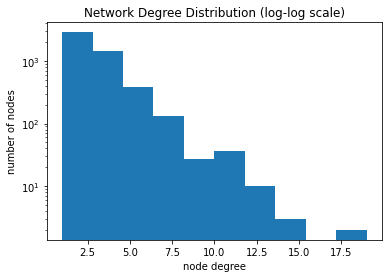

In [34]:
# get the degree sequence
wpower_deg_seq = [d for n, d in g.degree()]
plt.hist(wpower_deg_seq, log=True)
plt.title('Network Degree Distribution (log-log scale)')
plt.xlabel('node degree')
plt.ylabel('number of nodes')
plt.show()

**Does this network appear to be scale free?** 
- Yes, it seems like the nodes degree distribution follows a power law.  A relative change in the node degree proporty results in a proportional relative change in the number of nodes of that degree. There are many nodes that are relatively unconnected and few that are extremely connected.

### Problem 2D) Run the model on the Western United States power grid network, again with a random node chosen to be over capacity when you initialize the system (you can use 50-100% initial load for this model). 
However, don’t try to visualize it at every time step! This will probably be too slow to run. Instead, just run the model in a for loop (similar to Problem 1) for at least 20 simulations (even 20 simulations may take a while depending on how you code this and how fast your computer is), and at the end of each simulation tabulate the total number of failed nodes, i.e. the total size of the electrical blackout resulting from the node failure. Generate a histogram of the blackout sizes (i.e. the size of the cascades) from each simulation. How robust is this power network to random node failure? What percent of the time do more than 10% of the nodes fail?

In [35]:
western_power = Grid(init_load = 0.5, g = g)

In [36]:
import copy

t = 25
reps = 20

grid_props = []
blackout_size = []

print('number of nodes:', western_power.N)

for j in range(reps):
    grid = copy.deepcopy(western_power)
    grid.overload()
    for i in range(t):
        grid.update()
    grid_props.append(grid.prop)
    blackout_size.append(grid.prop[-1])
    # print(1-(sum([grid.g.nodes[n]['running'] for n in grid.g.nodes])/grid.N))  

number of nodes: 4941
overloaded nodes: [2848]
overloaded nodes: [554]
overloaded nodes: [578]
overloaded nodes: [484]
overloaded nodes: [2177]
overloaded nodes: [1424]
overloaded nodes: [2136]
overloaded nodes: [2231]
overloaded nodes: [914]
overloaded nodes: [2875]
overloaded nodes: [4702]
overloaded nodes: [4564]
overloaded nodes: [626]
overloaded nodes: [2691]
overloaded nodes: [2679]
overloaded nodes: [2993]
overloaded nodes: [4482]
overloaded nodes: [3032]
overloaded nodes: [3713]
overloaded nodes: [4647]


**Generate a histogram of the blackout sizes (i.e. the size of the cascades) from each simulation.**

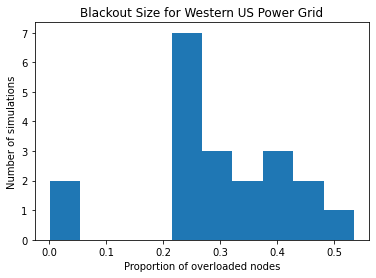

In [37]:
plt.hist(blackout_size)
plt.title('Blackout Size for Western US Power Grid')
plt.ylabel('Number of simulations')
plt.xlabel('Proportion of overloaded nodes')
plt.show()

**How robust is this power network to random node failure? What percent of the time do more than 10% of the nodes fail?**
- The network is not very robust to random node failures (at least of the initial size I created). None of the simulations resulted in a complete blackout across the network, but often 0.3-0.5 of the nodes in the power grid experienced a blackout. The maximum was greater than 0.6 nodes in the network having experienced a blackoud caused by a single failure. 
- Only 1/20 of the networks experienced less than a 10% failure rate. That is not good.